In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import ast
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

### Prepare dataset

In [2]:
df=pd.read_csv('dataset/SEntFiN-v1.1.csv')
df.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [3]:
# Convert 'Decisions' column from strings to dictionaries
df['Decisions'] = df['Decisions'].apply(ast.literal_eval)
# Normalize the 'Decisions' column
decisions_df = df['Decisions'].apply(pd.Series)
decisions_df.head()

,SpiceJet,MMTC,Mid-cap funds,Mid caps,Market,Infosys,Hudco,HOEC,Gold,Silver,...,pharmaceutical stocks,WhatsApp,BBM,FB,Indian cyclicals,Metro,"Masoor, gram",Wincor,masoor,Chambal
0,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,neutral,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Concatenate the original DataFrame with the normalized decisions
df_expanded = pd.concat([df.drop(columns='Decisions'), decisions_df], axis=1)
df_expanded.head()

,S No.,Title,Words,SpiceJet,MMTC,Mid-cap funds,Mid caps,Market,Infosys,Hudco,...,pharmaceutical stocks,WhatsApp,BBM,FB,Indian cyclicals,Metro,"Masoor, gram",Wincor,masoor,Chambal
0,1,SpiceJet to issue 6.4 crore warrants to promoters,8,neutral,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,MMTC Q2 net loss at Rs 10.4 crore,8,NaN,neutral,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"Mid-cap funds can deliver more, stay put: Experts",8,NaN,NaN,positive,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Mid caps now turn into market darlings,7,NaN,NaN,NaN,positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"Market seeing patience, if not conviction: Pra...",8,NaN,NaN,NaN,NaN,neutral,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Melt the expanded DataFrame to long format
df_long = df_expanded.melt(
    id_vars=["S No.", "Title", "Words"],
    var_name="Aspect",
    value_name="Sentiment"
).dropna(subset=["Sentiment"])
df_long.head()

,S No.,Title,Words,Aspect,Sentiment
0,1,SpiceJet to issue 6.4 crore warrants to promoters,8,SpiceJet,neutral
82,83,SpiceJet makes top-level changes,4,SpiceJet,neutral
1509,1510,Maran makes open offer for SpiceJet,6,SpiceJet,positive
1511,1512,"SpiceJet is a buy: CK Narayan, Sharyans Resources",8,SpiceJet,positive
1513,1514,SpiceJet: Regional focus can help airline soar...,8,SpiceJet,positive


In [6]:
# Select relevant columns for classification
df_absa = df_long[["Title", "Aspect", "Sentiment"]]
df_absa.head()

,Title,Aspect,Sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral
82,SpiceJet makes top-level changes,SpiceJet,neutral
1509,Maran makes open offer for SpiceJet,SpiceJet,positive
1511,"SpiceJet is a buy: CK Narayan, Sharyans Resources",SpiceJet,positive
1513,SpiceJet: Regional focus can help airline soar...,SpiceJet,positive


### CNN Classifier for sentiment analysis

In [7]:
# Menggabungkan Title dan Aspect sebagai fitur teks
df_absa['Text'] = df_absa['Title']

# Encode labels
label_encoder = LabelEncoder()
df_absa['Label'] = label_encoder.fit_transform(df_absa['Sentiment'])
df_absa

C:\Users\Mufti Alroaz\AppData\Local\Temp\ipykernel_9728\1632722565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_absa['Text'] = df_absa['Title']


,Title,Aspect,Sentiment,Text,Label
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,SpiceJet to issue 6.4 crore warrants to promoters,1
82,SpiceJet makes top-level changes,SpiceJet,neutral,SpiceJet makes top-level changes,1
1509,Maran makes open offer for SpiceJet,SpiceJet,positive,Maran makes open offer for SpiceJet,2
1511,"SpiceJet is a buy: CK Narayan, Sharyans Resources",SpiceJet,positive,"SpiceJet is a buy: CK Narayan, Sharyans Resources",2
1513,SpiceJet: Regional focus can help airline soar...,SpiceJet,positive,SpiceJet: Regional focus can help airline soar...,2
...,...,...,...,...,...
45926038,"German shares outperform on Metro, Deutsche Bank",Metro,positive,"German shares outperform on Metro, Deutsche Bank",2
45936795,"Masoor, gram prices weaken on sluggish demand","Masoor, gram",negative,"Masoor, gram prices weaken on sluggish demand",0
45947561,European shares dip early; Wincor sinks,Wincor,negative,European shares dip early; Wincor sinks,0
45958315,"Gram, masoor decline on subdued demand",masoor,negative,"Gram, masoor decline on subdued demand",0


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string

# Download stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')

# Preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df_absa['Processed_Title'] = df_absa['Title'].apply(preprocess_text)

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)

In [12]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len=50):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.vocab = self.build_vocab()

    def build_vocab(self):
        vocab = set()
        for text in self.texts:
            for word in text.split():
                vocab.add(word)
        word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # +1 to reserve 0 for padding
        word_to_idx['<PAD>'] = 0
        return word_to_idx

    def text_to_sequence(self, text):
        sequence = [self.vocab.get(word, 0) for word in text.split()]
        if len(sequence) < self.max_len:
            sequence.extend([0] * (self.max_len - len(sequence)))
        else:
            sequence = sequence[:self.max_len]
        return sequence

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        sequence = self.text_to_sequence(text)
        return torch.tensor(sequence), torch.tensor(label, dtype=torch.long)

In [13]:
X = df_absa['Text']
# X = tfidf.fit_transform(df_absa['Processed_Title']).toarray()
y = df_absa['Label']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [14]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = TextDataset(X_train, y_train)
valid_dataset = TextDataset(X_valid, y_valid)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

In [15]:
# Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.conv1 = nn.Conv2d(1, 100, (3, embed_size))
        self.pool = nn.MaxPool2d((2, 1))
        self.fc1 = nn.Linear(100 * ((50 - 3 + 1) // 2), num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = torch.relu(self.conv1(x)).squeeze(3)
        x = self.pool(x).squeeze(2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [16]:
# Hyperparameters
vocab_size = len(train_dataset.vocab) + 1
embed_size = 50
num_classes = len(label_encoder.classes_)
learning_rate = 0.001
num_epochs = 10

In [17]:
# run with cuda 12
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
# Initialize model, loss function, and optimizer
model = CNNModel(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


e:\PROJECT\Python-Pro\absa-financial-news\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


e:\PROJECT\Python-Pro\absa-financial-news\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/10], Train Loss: 0.9575, Valid Loss: 1.3975
Epoch [2/10], Train Loss: 0.6644, Valid Loss: 1.4891
Epoch [3/10], Train Loss: 0.4920, Valid Loss: 1.8762
Epoch [4/10], Train Loss: 0.3797, Valid Loss: 2.0220
Epoch [5/10], Train Loss: 0.3531, Valid Loss: 2.0197
Epoch [6/10], Train Loss: 0.3202, Valid Loss: 2.0610
Epoch [7/10], Train Loss: 0.3069, Valid Loss: 1.9577
Epoch [8/10], Train Loss: 0.2902, Valid Loss: 2.2494
Epoch [9/10], Train Loss: 0.2740, Valid Loss: 2.0735
Epoch [10/10], Train Loss: 0.2591, Valid Loss: 2.1985


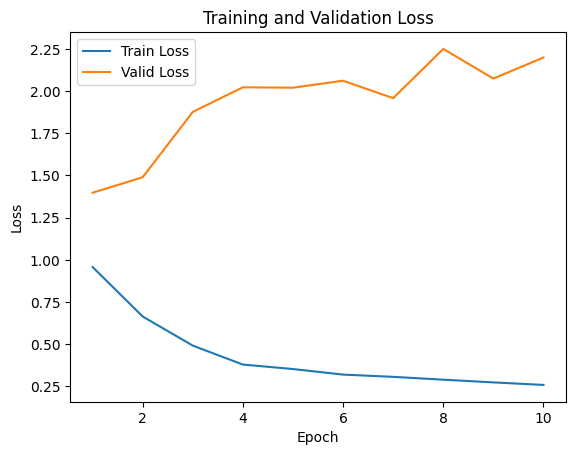

In [20]:
# Create DataLoader for validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

# Lists to store training and validation losses
train_losses = []
valid_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for texts, labels in valid_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
    valid_losses.append(epoch_valid_loss / len(valid_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}')

# Plotting the training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy:.4f}')
print(f'Classification Report:\n{report}')


Accuracy: 0.3591
Classification Report:
              precision    recall  f1-score   support

    negative       0.26      0.26      0.26       763
     neutral       0.39      0.62      0.48      1090
    positive       0.41      0.16      0.22      1029

    accuracy                           0.36      2882
   macro avg       0.35      0.35      0.32      2882
weighted avg       0.36      0.36      0.33      2882

